In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#df = pd.read_csv("iperf.csv", index_col = [1])
df = pd.read_csv("Teste2/teste2.csv")
#Remove colunas desnecessarias
del df['Timestamp']
del df['?']
del df['ForaOrdem']
del df['Tempo']
dfServer = df[df.IpOri != '10.1.0.2']
dfCliente = df[df.IpOri != '10.1.0.1']
df = dfServer
df = df.reset_index(drop=True)
df

,IpOri,PortaOri,IpDest,PortaDest,BitsEnv,Banda,Jitter,PctPerdido,PctEnv,%Perda
0,10.1.0.1,5086,10.1.0.2,5586,24526950,27348002,1.399,355604.0,372289.0,95.518
1,10.1.0.1,5038,10.1.0.2,5538,24663660,26722082,0.084,7298.0,24076.0,30.312
2,10.1.0.1,5068,10.1.0.2,5568,38971170,38825719,0.959,127870.0,154381.0,82.828
3,10.1.0.1,5076,10.1.0.2,5576,39006450,38837550,0.945,61368.0,87903.0,69.813
4,10.1.0.1,5043,10.1.0.2,5543,69156150,165460030,0.217,98992.0,146037.0,67.786
5,10.1.0.1,5052,10.1.0.2,5552,198148650,158766659,0.248,233860.0,368655.0,63.436
6,10.1.0.1,5046,10.1.0.2,5546,106948380,85784841,0.096,8387.0,81141.0,10.336
7,10.1.0.1,5060,10.1.0.2,5560,20256600,21642048,0.111,6729.0,20509.0,32.810
8,10.1.0.1,5016,10.1.0.2,5516,57734250,66250332,0.120,23141.0,62416.0,37.075
9,10.1.0.1,5003,10.1.0.2,5503,245490,8767421,323.213,259860.0,260027.0,99.936


In [3]:
# Função para cálculo do intervalo de confiança de 95%
def confinterval (data):
    confidence = 0.95
    return st.sem (data) * st.t.ppf ((1 + confidence) / 2.0, len (data) - 1);

/home/pedro/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/home/pedro/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/pedro/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


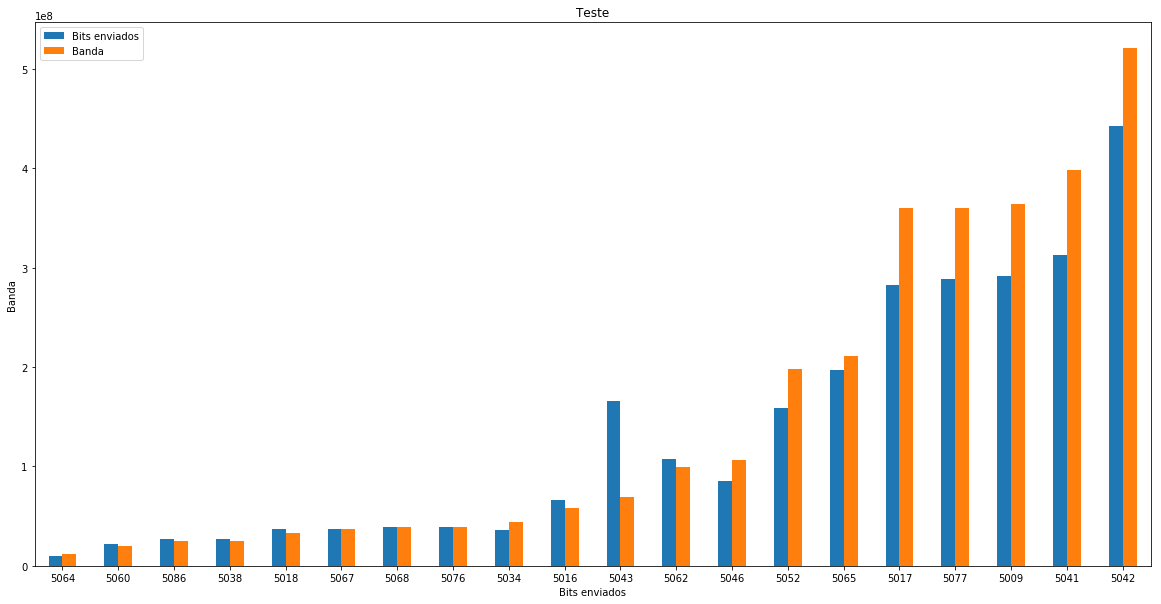

In [4]:
#Removendo trafegos pequenos
df = df.query("BitsEnv > 1000000")

gpb = df.groupby (['PortaOri'])
media = gpb.mean()
err = gpb.aggregate(confinterval)
err = err.filter(items=['Banda', 'BitsEnv'])
media = media.filter(items=['Banda', 'BitsEnv'])
#display (media)
#display (err)

media.sort_values(by=["BitsEnv"]).plot (kind='bar', yerr=err, title="Teste", rot=360, figsize=(20,10))
plt.xlabel('Bits enviados')
plt.ylabel('Banda')
plt.gca().legend(('Bits enviados','Banda'))
#plt.savefig('grafico_teste'.pdf')